In [1]:
cd "C:\\Users\\Piquant Mark\\Desktop\\CENTRALE\\3A\\MMF\\SD9\\Machine_Learning\\Kaagle\\input\\automated-sleep-staging-beacon-biosignals-2023-2024"

C:\Users\Piquant Mark\Desktop\CENTRALE\3A\MMF\SD9\Machine_Learning\Kaagle\input\automated-sleep-staging-beacon-biosignals-2023-2024


In [69]:
import numpy as np
import os
import random as rd
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import spectrogram

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree, svm, neighbors, linear_model, ensemble, neural_network
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeCV, LassoCV


import xgboost as xgb

## Modèle du TD 2 :

In [5]:
frequency_bands = {
        "delta": [0.5, 4],
        "theta": [4, 8],
        "alpha": [8, 12],
       "sigma": [12, 16],
       "beta": [16, 30]
    }

statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

def get_relative_spectral_power_for_epoch(data):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    EEG_FS = 250
    psds = []
    sfreqs,t,psd = spectrogram(data,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)
        spectral_power_band[name] = spec_power / np.sum(psd,1)
    return spectral_power_band

def compute_stats(data):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {k:f(data) for k,f in statistics.items()}
    return result

def build_dataset(records, data_for_records,hypnogram_for_records):
    X,y = [],[]
    for record in records:
        X_for_record = np.expand_dims(np.array([value for value in data_for_records[record].values()]).T,0)
        y.extend(hypnogram_for_records[record])
        X.extend(X_for_record)
    return np.concatenate(X),y

In [6]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1: 250*30 +1 ]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())

In [18]:
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
print('Training records: ',training_record)
print('Test records: ', test_records)

X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)
# print(variable_lists)
# print(X_train[0])
# print(y_train[0])

# modele : # linear classifier
pipeline = make_pipeline(StandardScaler(),LogisticRegression(max_iter = 200)) # scale input data and reduce dimension
pipeline.fit(X_train, y_train)

Training records:  ['dreem_1.npy', 'dreem_2.npy', 'dreem_5.npy', 'dreem_4.npy']
Test records:  ['dreem_0.npy', 'dreem_3.npy', 'dreem_6.npy']


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

{'balanced_accuracy': 0.4516066509911415, 'cohen_kappa': 0.45545669760046525, 'macro_f1': 0.43169611023723087}


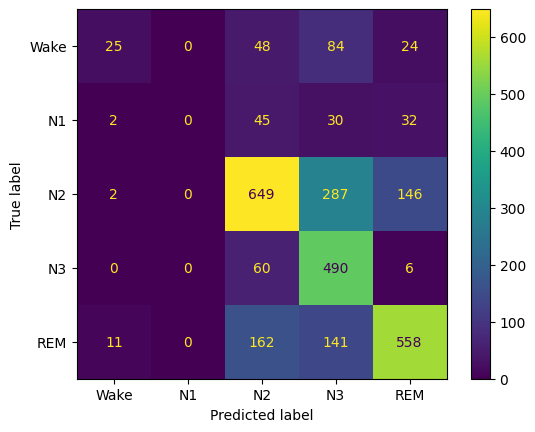

In [19]:
# test it
predictions = pipeline.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(pipeline, X_test,y_test,display_labels = ['Wake','N1','N2','N3','REM'])

- Balanced_accuracy : 0.45161
- Cohen_kappa : 0.45546
- Macro_f1 : 0.43170
- Score Kaggle : 0.45548

# On ajoute d'autres statistiques pour aider la régression : 

In [7]:
statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1),
    "max":lambda x:np.max(np.abs(x),1),
    "min":lambda x:np.min(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

def get_relative_spectral_power_for_epoch(data):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    EEG_FS = 250
    psds = []
    sfreqs,t,psd = spectrogram(data,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)
        spectral_power_band[name] = spec_power / np.sum(psd,1)
    return spectral_power_band

def compute_stats(data):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {k:f(data) for k,f in statistics.items()}
    return result

In [8]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1: 250*30 +1 ]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())

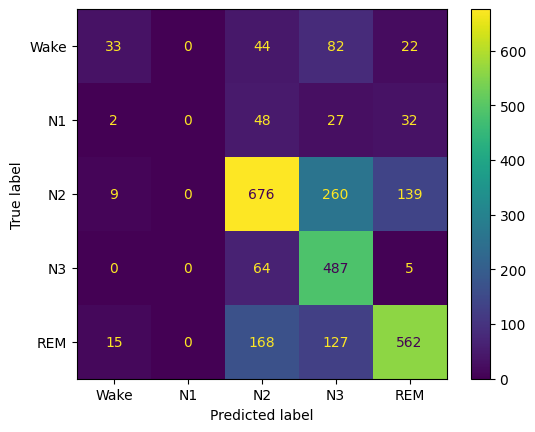

In [9]:
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]

X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)

# modele : 
pipeline = make_pipeline(StandardScaler(),LogisticRegression(max_iter = 200))
pipeline.fit(X_train, y_train)

# test it
predictions = pipeline.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}
ConfusionMatrixDisplay.from_estimator(pipeline, X_test,y_test,display_labels = ['Wake','N1','N2','N3','REM'])

c'est mieux : 
| Score type       | LR with First EEG (Frontal-occipital) and 2 stats | LR with First EEG (Frontal-occipital) 4 stats |
|:----------------:|:---------------:|:---------------:|
| Balanced Accuracy| 0.4516 | 0.4653 |
| Cohen Kappa      | 0.4555 | 0.4727 |
| Macro F1         | 0.4317 | 0.4491 |
| Score Kaggle     | 0.4555 | Non_submit |

## Utilisation de différents capteurs pour voir si un est plus efficace que le premier : 

{'balanced_accuracy': 0.4652662743141776, 'cohen_kappa': 0.4726604518233065, 'macro_f1': 0.4490712763911879}
{'balanced_accuracy': 0.3779325254474403, 'cohen_kappa': 0.3338422006933096, 'macro_f1': 0.3480621290886665}
{'balanced_accuracy': 0.48057308996619075, 'cohen_kappa': 0.5679078610706407, 'macro_f1': 0.44565576372367166}
{'balanced_accuracy': 0.39119945768763875, 'cohen_kappa': 0.35387171976721454, 'macro_f1': 0.37061649323786805}
{'balanced_accuracy': 0.31348942887156567, 'cohen_kappa': 0.2023693083697753, 'macro_f1': 0.26513076375138345}
{'balanced_accuracy': 0.24719696818084302, 'cohen_kappa': 0.0938676526273392, 'macro_f1': 0.21387740985065004}
{'balanced_accuracy': 0.2565610690886627, 'cohen_kappa': 0.10960025785228955, 'macro_f1': 0.23254448667068844}
{'balanced_accuracy': 0.2775312453669438, 'cohen_kappa': 0.16037850502454665, 'macro_f1': 0.2726615086476385}


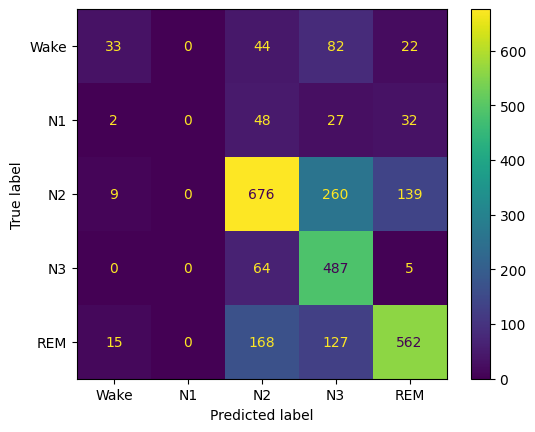

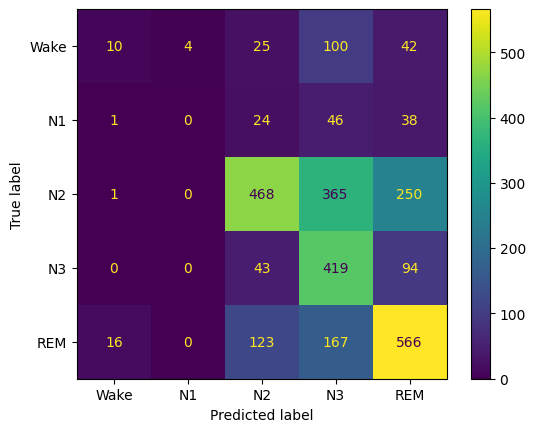

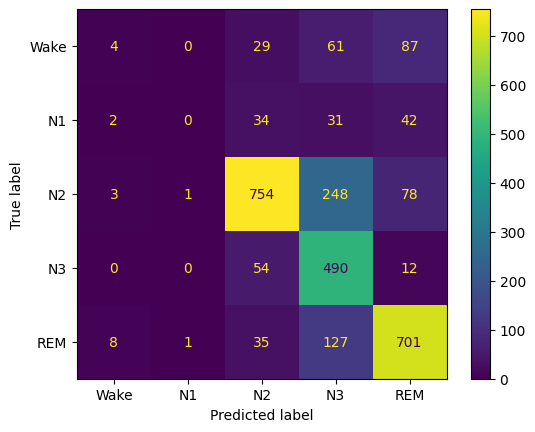

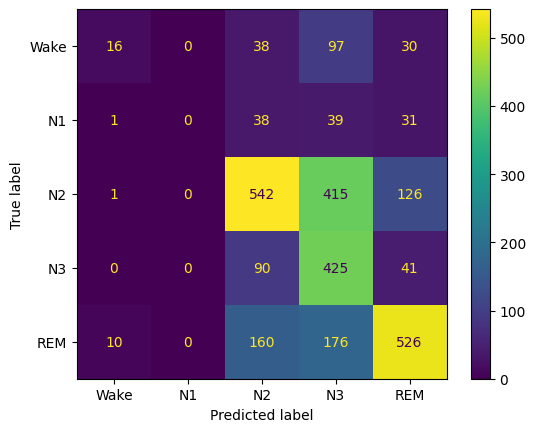

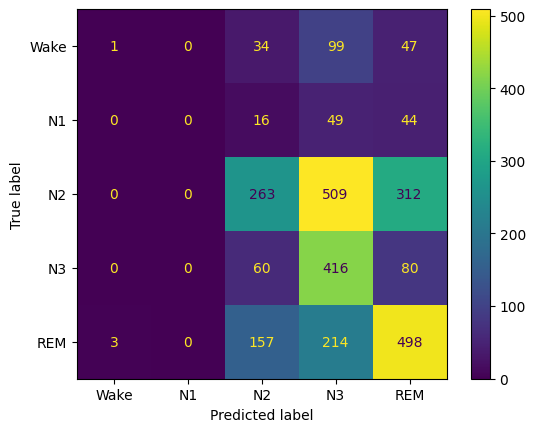

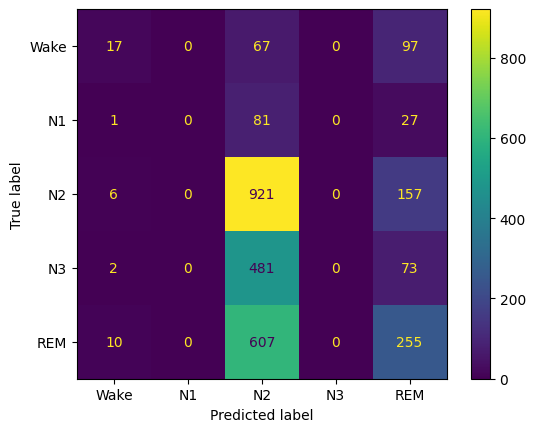

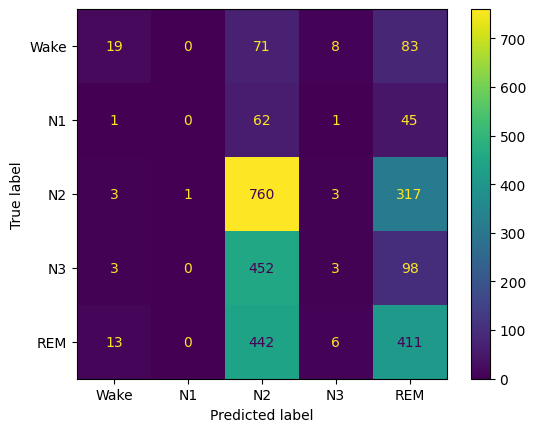

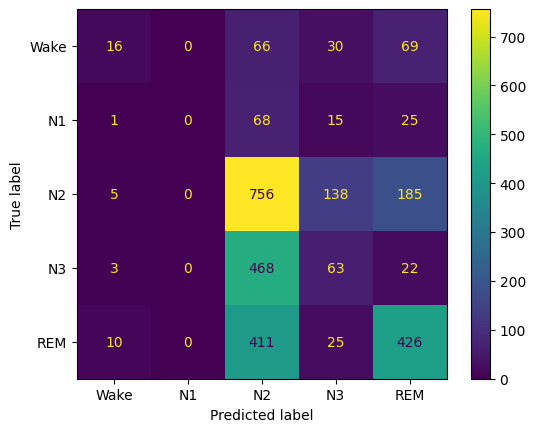

In [35]:
statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1),
    "max":lambda x:np.max(np.abs(x),1),
    "min":lambda x:np.min(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

def get_relative_spectral_power_for_epoch(data):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    EEG_FS = 250
    psds = []
    sfreqs,t,psd = spectrogram(data,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)
        spectral_power_band[name] = spec_power / np.sum(psd,1)
    return spectral_power_band

def compute_stats(data):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {k:f(data) for k,f in statistics.items()}
    return result

rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record, test_records = records_list[:4], records_list[4:]

channels = {
    "EEG1": (1, 7501),
    "EEG2": (7501, 15001),
    "EEG3": (15001, 22501),
    "EEG4": (22501, 30001),
    "EEG5": (30001, 37501),
    "ACC_X": (37501, 39001),
    "ACC_Y": (39001, 40501),
    "ACC_Z": (40501, 42001)
}

for channel, (start, end) in channels.items():
    # print(f"Processing {channel}...")
    data_for_records = {}
    hypnogram_for_records = {}
    hypnograms = pd.read_csv('targets_train.csv')

    for record in os.listdir("training_records"):
        record_number = int(record[-5])
        x = np.load(f'training_records/{record}')
        data_for_channel = x[:, start:end]
        data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_channel)
        data_for_records[record].update(compute_stats(data_for_channel))
        hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

    variable_list = list(data_for_records[record].keys())

    X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
    X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

    pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)
    scores = {
        'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
        'cohen_kappa': cohen_kappa_score(y_test, predictions),
        'macro_f1': f1_score(y_test, predictions, average='macro')
    }

    print(scores)
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
    

les autres capteurs seules ne suffisent pas 
| Score type       | LR with EEG1 (Frontal-occipital) and 2 stats | LR with First EEG1 (Frontal-occipital) 4 stats | EEG2 | EEG3 | EEG4 | EEG5 | ACC_X | ACC_Y | ACC_Z |
|:----------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|
| Balanced Accuracy| 0.4516 | 0.4653 | 0.3310 | 0.4419 | 0.3441 | 0.3072 | 0.2359 | 0.2668 | 0.3024 |
| Cohen Kappa      | 0.4555 | 0.4727 | 0.2766 | 0.5061 | 0.2611 | 0.2157 | 0.0680 | 0.1150 | 0.1391 |
| Macro F1         | 0.4317 | 0.4491 | 0.3126 | 0.4194 | 0.3368 | 0.2888 | 0.2155 | 0.2694 | 0.3014 |
| Score Kaggle     | 0.4555 | NA | NA | 0.31 | NA | NA | NA | NA | NA |

Quand on observe les confusion matrixes, il semble que

- Le capteur EGG1 soit le meilleur pour prédire Wake (alpha)
- Aucun capteur ne prédit un seul N1 correctement (mvt oculaires lents)
- Le capteur EGG3 soit le meilleur pour prédire N2 (sleep spindles et FF + K complexe)
- Le capteur EGG1 soit le meilleur pour prédire N3 (ondes delta en majo)
- Le capteur EGG3 soit le meilleur pour prédire REM (commen prévu par le TP1 car FO et FF)

J'ai également testé de mettre tous les capteurs et le résultat est pire.

On note qu'on devra tester avec la cross validation et du ridge.
Il faut d'abord essayer d'équilibrer nos entrée car : 

In [22]:
# on compte le nombre de chaque label dans hypnogram_for_records
label_count = {}
for record in hypnogram_for_records:
    for label in hypnogram_for_records[record]:
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1
print(label_count)

{0: 389, 1: 244, 2: 2317, 3: 1375, 4: 1850}


In [35]:
# Initialize a new dictionary for balanced data
balanced_data_for_records = {}
balanced_hypnogram_for_records = {}

# Define the maximum number of samples per class
max_samples = 100

# Loop over the records
# Loop over the records
for record in data_for_records.keys():
    # Get the data and labels for this record
    data = data_for_records[record]
    labels = hypnogram_for_records[record]

    # Combine the data and labels into a single DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels

    # Initialize a DataFrame for the balanced data
    balanced_df = pd.DataFrame()

    # Loop over the unique labels
    for label in df['label'].unique():
        # Get the samples for this label
        label_df = df[df['label'] == label]

        # If the label is 0 or 1, keep all samples. Otherwise, resample the data to have at most max_samples samples
        if label in [0, 1]:
            resampled_df = label_df
        else:
            resampled_df = resample(label_df, replace=False, n_samples=min(len(label_df), max_samples), random_state=42)

        # Append the resampled data to the balanced data
        balanced_df = pd.concat([balanced_df, resampled_df])

    # Shuffle the balanced data
    balanced_df = balanced_df.sample(frac=1, random_state=42)
    # print(balanced_df['label'].value_counts())
    # Split the balanced data back into data and labels
    balanced_data_for_records[record] = balanced_df.drop('label', axis=1).to_dict('list')
    balanced_hypnogram_for_records[record] = balanced_df['label'].tolist()

In [36]:
variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(balanced_data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, balanced_data_for_records, balanced_hypnogram_for_records)
X_test, y_test = build_dataset(test_records, balanced_data_for_records, balanced_hypnogram_for_records)

{'balanced_accuracy': 0.46067403314917127, 'cohen_kappa': 0.41679920234489565, 'macro_f1': 0.43112201988346827}


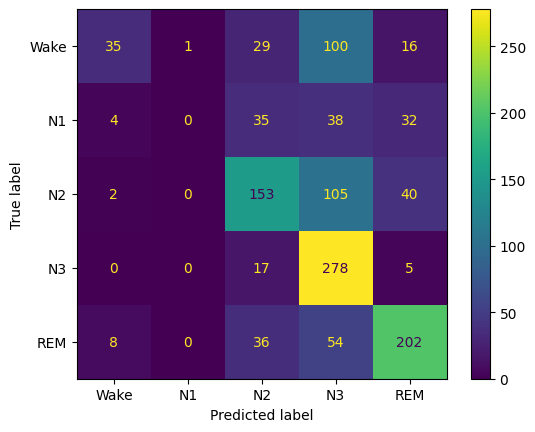

In [37]:

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
scores = {
    'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
    'cohen_kappa': cohen_kappa_score(y_test, predictions),
    'macro_f1': f1_score(y_test, predictions, average='macro')
}

print(scores)
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])


### essayons maintenant avec de la CV

In [41]:
statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1),
    "max":lambda x:np.max(np.abs(x),1),
    "min":lambda x:np.min(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

In [43]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1: 250*30 +1 ]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())

In [44]:
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]

X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)

Cross-validation scores: [0.64592593 0.48888889 0.60148148 0.68545994 0.65430267]
Mean cross-validation score: 0.6152117815144521
{'balanced_accuracy': 0.4652662743141776, 'cohen_kappa': 0.4726604518233065, 'macro_f1': 0.4490712763911879}


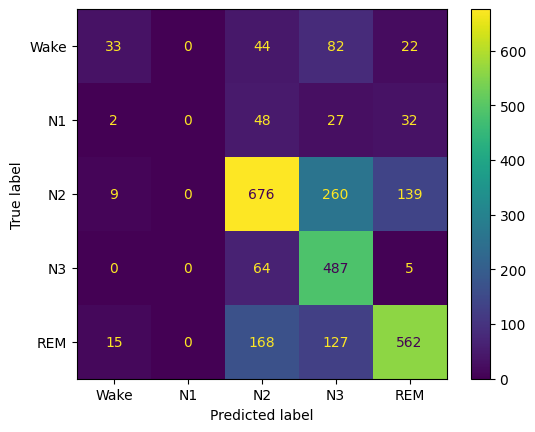

In [47]:
# Create the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

# Perform cross-validation
cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Test it
predictions = pipeline.predict(X_test)
scores = {
    'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
    'cohen_kappa': cohen_kappa_score(y_test, predictions),
    'macro_f1': f1_score(y_test, predictions, average='macro')
}
print(scores)
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])

Avec du ridge : 

In [71]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1: 250*30 +1 ]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]

X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

Best alpha: 10.0
{'balanced_accuracy': 0.2771775961703364, 'cohen_kappa': 0.136700338979036, 'macro_f1': 0.23095750803338494}


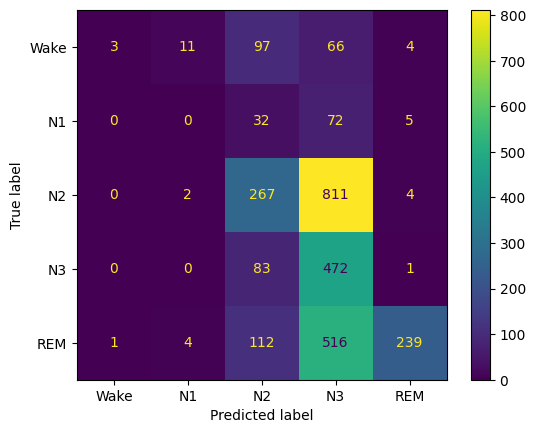

In [76]:
# Define the alphas
alphas = [0.1, 1.0, 10.0]

# Create the RidgeCV object
ridge = RidgeCV(alphas=alphas, cv=5)

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Print the best alpha
print(f"Best alpha: {ridge.alpha_}")

# Make predictions
predictions = ridge.predict(X_test_scaled)
predictions = np.round(predictions).astype(int)
predictions = np.clip(predictions, 0, 4)

# Calculate scores...
scores = {
    'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
    'cohen_kappa': cohen_kappa_score(y_test, predictions),
    'macro_f1': f1_score(y_test, predictions, average='macro')
}
print(scores)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
disp.plot()

ridge pu car c'est en continue donc dur de classer

##  voyons ce qu'il reste pour la logistique

-------
## Trees

In [85]:
statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1),
    "max":lambda x:np.max(np.abs(x),1),
    "min":lambda x:np.min(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

def get_relative_spectral_power_for_epoch(data):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    EEG_FS = 250
    psds = []
    sfreqs,t,psd = spectrogram(data,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)
        spectral_power_band[name] = spec_power / np.sum(psd,1)
    return spectral_power_band

def compute_stats(data):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {k:f(data) for k,f in statistics.items()}
    return result

In [86]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:7501]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)


{'balanced_accuracy': 0.47554733717585407, 'cohen_kappa': 0.3579935270725374, 'macro_f1': 0.4290912514619379}


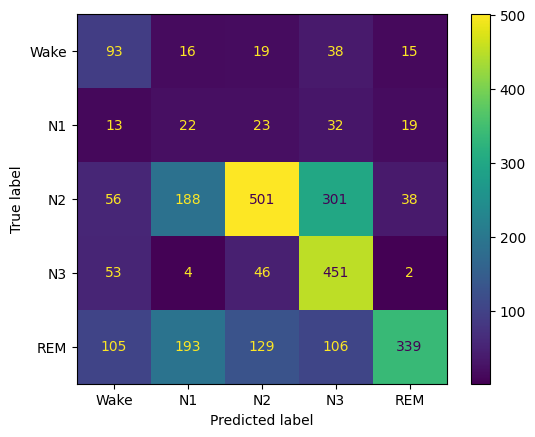

In [87]:
clf = tree.DecisionTreeClassifier(random_state=1234,max_depth = 4, class_weight = 'balanced')
clf.fit(X_train[:,:len(frequency_bands)],y_train)

# test it
predictions = clf.predict(X_test[:,:len(frequency_bands)])
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

en augmenant le max_depth

{'balanced_accuracy': 0.45846484482191013, 'cohen_kappa': 0.4309319994231373, 'macro_f1': 0.4471364426071932}


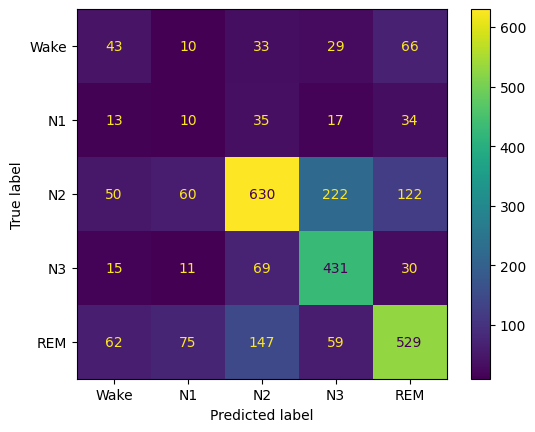

In [93]:
clf = tree.DecisionTreeClassifier(random_state=1234, max_depth = 30, class_weight = 'balanced')
clf.fit(X_train[:,:len(frequency_bands)],y_train)

# test it
predictions = clf.predict(X_test[:,:len(frequency_bands)])
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

avec tout le jeu de données

In [94]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

{'balanced_accuracy': 0.3679325981560754, 'cohen_kappa': 0.30694360253394704, 'macro_f1': 0.35781724894537187}


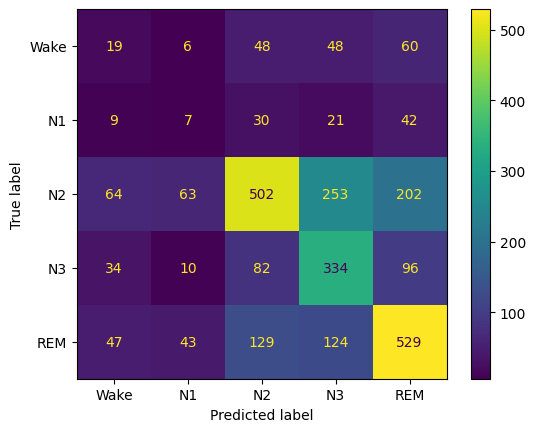

In [95]:
clf = tree.DecisionTreeClassifier(random_state=1234,max_depth = 30, class_weight = 'balanced')
clf.fit(X_train[:,:len(frequency_bands)],y_train)

# test it
predictions = clf.predict(X_test[:,:len(frequency_bands)])
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

Performance médiocre si on lui donne 1 seul capteur. Bonne si on lui donne tout le jeu de données.

| Score type       | EGG1, Tree depth = 4 | EGG1, tree depth = 10 | all data, tree depth = 10 |
|:----------------:|:---------------:|:---------------:|:---------------:|
| Balanced Accuracy| 0.45161 | 0.46142 | 0.38969 |
| Cohen Kappa      | 0.45546 | 0.39117 | 0.28632 |
| Macro F1         | 0.43170 | 0.43605 | 0.36399 |
| Score Kaggle     | NA | **0.4650** | NA |

-------
## Gradient Boosting : 
avec tout le jeu de données

In [100]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

{'balanced_accuracy': 0.458005257320744, 'cohen_kappa': 0.46709139161947155, 'macro_f1': 0.4527984057012938}


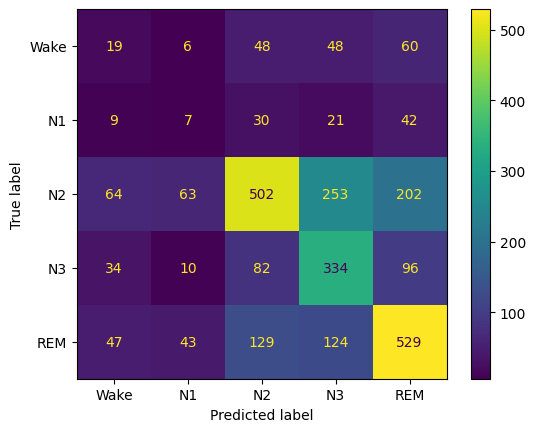

In [101]:
# Create a GradientBoostingClassifier object
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
# Train the model
gb_clf.fit(X_train, y_train)
# Make predictions
predictions = gb_clf.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

avec seulement le premier capteur: 

In [56]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:7501]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

In [64]:
# Create a GradientBoostingClassifier object
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
# Train the model
gb_clf.fit(X_train, y_train)
# Make predictions
predictions = gb_clf.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(gb_clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

{'balanced_accuracy': 0.5202090395191192, 'cohen_kappa': 0.5558645268035372, 'macro_f1': 0.5108248370238735}


ValueError: X has 5 features, but GradientBoostingClassifier is expecting 9 features as input.

In [63]:
print(predictions)

      identifier  target
0          70000       3
1          70001       2
2          70002       3
3          70003       0
4          70004       3
...          ...     ...
2641       90842       4
2642       90843       0
2643       90844       4
2644       90845       4
2645       90846       2

[2646 rows x 2 columns]


In [65]:
print(predictions)

[0 0 2 ... 0 0 4]


In [62]:
predictions = []
for record in os.listdir("test_records"):
    record_number = int(record[-5])
    x = np.load(f'test_records/{record}')
    raw_data_for_record = x[:,1:250 * 30 + 1]
    data_for_record = get_relative_spectral_power_for_epoch(raw_data_for_record)
    data_for_record.update(compute_stats(raw_data_for_record))
    data_for_record = np.array([value for value in data_for_record.values()]).T
    preds = gb_clf.predict(data_for_record)  # Use gb_clf instead of pipeline
    for i, pred in enumerate(preds):
        predictions.append({"identifier":record_number * 10000 + i,'target':pred})

predictions = pd.DataFrame(predictions)

predictions.to_csv('C:\\Users\\Piquant Mark\\Desktop\\CENTRALE\\3A\\MMF\\SD9\\Machine_Learning\\Kaagle\\Working\\submission_gradientboosting1.csv',index = None)

| Score type       | EGG1, Tree depth = 4 | EGG1, tree depth = 10 | Gradient Boosting EGG1 | all data, tree depth = 10 | Gradient Boosting all variables |
|:----------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|
| Balanced Accuracy| 0.45161 | 0.46142 | 0.50994 | 0.38969 | 0.43953 |
| Cohen Kappa      | 0.45546 | 0.39117 | 0.54752 | 0.28632 | 0.44435 |
| Macro F1         | 0.43170 | 0.43605 | 0.50357 | 0.36399 | 0.42481 |
| Score Kaggle     | NA | **0.4650** | NA | NA | NA |


On va essayer avec EGG1 et EGG3 : 

In [98]:
channels = {
    "EEG1": (1, 7501),
    "EEG2": (7501, 15001),
    "EEG3": (15001, 22501),
    "EEG4": (22501, 30001),
    "EEG5": (30001, 37501),
    "ACC_X": (37501, 39001),
    "ACC_Y": (39001, 40501),
    "ACC_Z": (40501, 42001)
}

data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:7501] + x[:,15001:22501] # EEG1 + EEG3
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

{'balanced_accuracy': 0.5105562202038153, 'cohen_kappa': 0.5571702797101868, 'macro_f1': 0.49575053401405517}


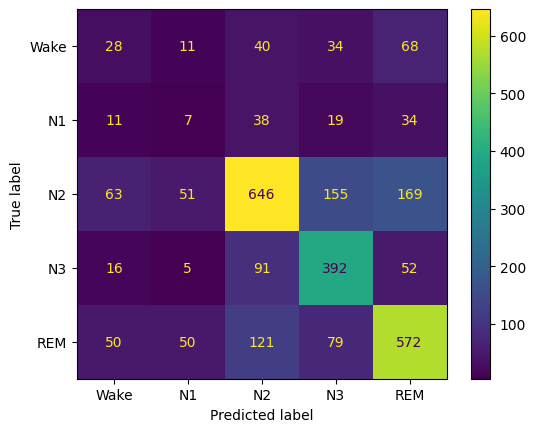

In [99]:
# Create a GradientBoostingClassifier object
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
# Train the model
gb_clf.fit(X_train, y_train)
# Make predictions
predictions = gb_clf.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

| Score type       | Tree, EGG1, max_depth=4 | Tree, EGG1, max_depth=30 | Tree, all data, max_depth=30 | Gradient Boosting, EGG1, max_depth=10 | Gradient Boosting EGG1+EGG3, max_depth=10 | Gradient Boosting, all_data, max_depth=10 |
|:----------------:|:-----------------------:|:------------------------:|:-----------------------------:|:-------------------------------------:|:----------------------------------------:|:---------------------------------------:|
| Balanced Accuracy| 0.47555                 | 0.45846                  | 0.36793                       | 0.52021                               | 0.51056                                 | 0.45801                                |
| Cohen Kappa      | 0.35799                 | 0.43093                  | 0.30694                       | 0.55586                               | 0.55717                                 | 0.46709                                |
| Macro F1         | 0.42909                 | 0.44714                  | 0.35782                       | 0.51082                               | 0.49575                                 | 0.45280                                |

Mettre plus de données ou toutes les données rajoute du bruit dans le modèle. (Augmenter la max depth aide le modèle) (risque de surapprentissage ?)

------
# XGBoosting : 
On sort l'artillerie lourde

In [48]:
statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1),
    "max":lambda x:np.max(np.abs(x),1),
    "min":lambda x:np.min(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

In [66]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:7501]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

C:\Users\Piquant Mark\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'balanced_accuracy': 0.5145988171177687, 'cohen_kappa': 0.5526714187162776, 'macro_f1': 0.5000598526372182}


Text(0.5, 1.0, 'XGBoost, max_depth=3')

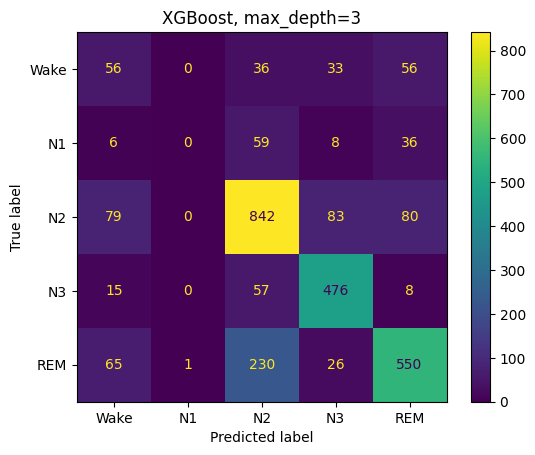

In [67]:
# Create a XGBClassifier object
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# Train the model
xgb_clf.fit(X_train, y_train)
# Make predictions
predictions = xgb_clf.predict(X_test)
# Calculate scores
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
          'cohen_kappa': cohen_kappa_score(y_test, predictions),
          'macro_f1': f1_score(y_test, predictions, average='macro')}
print(scores)

# Display confusion matrix
disp=ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
disp.ax_.set_title('XGBoost, max_depth=3')



# # Create a XGBClassifier object
# xgb_clf2 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=20, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# # Train the model
# xgb_clf2.fit(X_train, y_train)
# # Make predictions
# predictions = xgb_clf2.predict(X_test)
# # Calculate scores
# scores2 = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
#           'cohen_kappa': cohen_kappa_score(y_test, predictions),
#           'macro_f1': f1_score(y_test, predictions, average='macro')}

# print(scores2, 'max_depth=10')
# # Display confusion matrix
# disp2=ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
# disp2.ax_.set_title('XGBoost, max_depth=10')
# plt.show()

In [68]:
predictions = []
for record in os.listdir("test_records"):
    record_number = int(record[-5])
    x = np.load(f'test_records/{record}')
    raw_data_for_record = x[:,1:250 * 30 + 1]
    data_for_record = get_relative_spectral_power_for_epoch(raw_data_for_record)
    data_for_record.update(compute_stats(raw_data_for_record))
    data_for_record = np.array([value for value in data_for_record.values()]).T
    preds = xgb_clf.predict(data_for_record)  # Use gb_clf instead of pipeline
    for i, pred in enumerate(preds):
        predictions.append({"identifier":record_number * 10000 + i,'target':pred})

predictions = pd.DataFrame(predictions)

predictions.to_csv('C:\\Users\\Piquant Mark\\Desktop\\CENTRALE\\3A\\MMF\\SD9\\Machine_Learning\\Kaagle\\Working\\submission_xg2.csv',index = None)

In [104]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

C:\Users\Piquant Mark\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'balanced_accuracy': 0.4521923866285646, 'cohen_kappa': 0.4442655842808053, 'macro_f1': 0.4371357379488849}


C:\Users\Piquant Mark\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'balanced_accuracy': 0.46164377907333687, 'cohen_kappa': 0.4686583727596366, 'macro_f1': 0.4506463314935833} max_depth=10


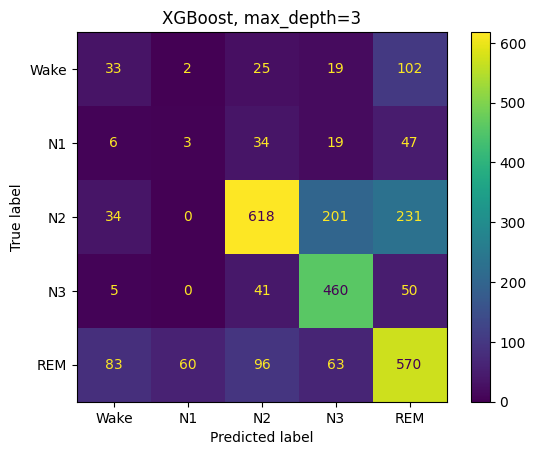

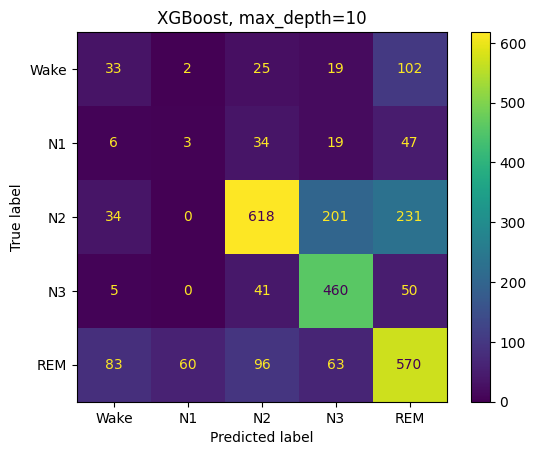

In [105]:
# Create a XGBClassifier object
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# Train the model
xgb_clf.fit(X_train, y_train)
# Make predictions
predictions = xgb_clf.predict(X_test)
# Calculate scores
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
          'cohen_kappa': cohen_kappa_score(y_test, predictions),
          'macro_f1': f1_score(y_test, predictions, average='macro')}
print(scores)

# Display confusion matrix
disp=ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
disp.ax_.set_title('XGBoost, max_depth=3')



# Create a XGBClassifier object
xgb_clf2 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# Train the model
xgb_clf2.fit(X_train, y_train)
# Make predictions
predictions = xgb_clf2.predict(X_test)
# Calculate scores
scores2 = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
          'cohen_kappa': cohen_kappa_score(y_test, predictions),
          'macro_f1': f1_score(y_test, predictions, average='macro')}

print(scores2, 'max_depth=10')
# Display confusion matrix
disp2=ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
disp2.ax_.set_title('XGBoost, max_depth=10')
plt.show()

| Score type       | XGboosting, EGG1, max_depth=10 | XGboosting, all data, max_depth=10 | Gradient Boosting, EGG1, max_depth=10 | Gradient Boosting EGG1+EGG3, max_depth=10 | Gradient Boosting, all_data, max_depth=10 |
|:----------------:|:-----------------------------:|:----------------------------------:|:-------------------------------------:|:----------------------------------------:|:---------------------------------------:|
| Balanced Accuracy| 0.52126                       | 0.46164                            | 0.52021                               | 0.51056                                 | 0.45801                                |
| Cohen Kappa      | 0.55707                       | 0.46866                            | 0.55586                               | 0.55717                                 | 0.46709                                |
| Macro F1         | 0.50329                       | 0.45065                            | **0.51082**                               | 0.49575                                 | 0.45280                                |

Gradient Boosting est meilleur que le XGB ? 

# comment savoir quels paramètres on prend pour maximiser notre xgBoosting ? 

In [ ]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:7501]
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]
X_train, y_train = build_dataset(training_record, data_for_records, hypnogram_for_records)
X_test, y_test = build_dataset(test_records, data_for_records, hypnogram_for_records)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 500],
#     'subsample': [0.5, 0.7, 1],
#     'colsample_bytree': [0.5, 0.7, 1],
# }

# # Create a XGBClassifier object
# xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# # Create the grid search object
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(best_params)

# # Train the model with the best parameters
# xgb_clf_best = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# xgb_clf_best.fit(X_train, y_train)

# # Make predictions
# predictions = xgb_clf_best.predict(X_test)

# # Calculate scores
# scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
#           'cohen_kappa': cohen_kappa_score(y_test, predictions),
#           'macro_f1': f1_score(y_test, predictions, average='macro')}
# print(scores)

- max_depth=5 et learning_rate de 0.1
- {'balanced_accuracy': 0.521864488183734, 'cohen_kappa': 0.5600968931257926, 'macro_f1': 0.506665081742738}

| Score type       | XGboosting, EGG1, max_depth=10 | XGboosting, all data, max_depth=10 | XGboosting, EEG1, para_opt | Gradient Boosting, EGG1, max_depth=10 | Gradient Boosting EGG1+EGG3, max_depth=10 | Gradient Boosting, all_data, max_depth=10 |
|:----------------:|:-----------------------------:|:----------------------------------:|:--------------------------:|:-------------------------------------:|:----------------------------------------:|:---------------------------------------:|
| Balanced Accuracy| 0.52126                       | 0.46164                            | 0.52186                    | 0.52021                               | 0.51056                                 | 0.45801                                |
| Cohen Kappa      | 0.55707                       | 0.46866                            | 0.56010                    | 0.55586                               | 0.55717                                 | 0.46709                                |
| Macro F1         | 0.50329                       | 0.45065                            | 0.50667                    | **0.51082**                           | 0.49575                                 | 0.45280                                |

---------

## Idée pour améliorer le code : 
1. Réglage des hyperparamètres (fait)
2. Cross validation ? 
3. augmenter le dataset avec un AE ? 
4. Equilibrer les classes : (à faire)
5. 

---------

In [61]:
print(predictions)

      identifier  target
0          70000       0
1          70001       0
2          70002       0
3          70003       0
4          70004       3
...          ...     ...
2641       90842       0
2642       90843       0
2643       90844       0
2644       90845       4
2645       90846       2

[2646 rows x 2 columns]


In [60]:
predictions = []
for record in os.listdir("test_records"):
    record_number = int(record[-5])
    x = np.load(f'test_records/{record}')
    raw_data_for_record = x[:,1:250 * 30 + 1]
    data_for_record = get_relative_spectral_power_for_epoch(raw_data_for_record)
    data_for_record.update(compute_stats(raw_data_for_record))
    data_for_record = np.array([value for value in data_for_record.values()]).T
    preds = pipeline.predict(data_for_record)
    for i, pred in enumerate(preds):
        predictions.append({"identifier":record_number * 10000 + i,'target':pred})

predictions = pd.DataFrame(predictions)

predictions.to_csv('C:\\Users\\Piquant Mark\\Desktop\\CENTRALE\\3A\\MMF\\SD9\\Machine_Learning\\Kaagle\\Working\\submission_gradientboosting1.csv',index = None)